In [3]:
#!/usr/bin/python

import numpy as np
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib as mp
import datetime
import os
#import seaborn as sns
#sns.set()
import warnings
warnings.filterwarnings('ignore')
import sys
#sys.path.append('/home2/datahome/cdemarez/MODULES_PY') 
#from tools import *
#from croco_tools_cdm import *
#from plot_tools import *
import matplotlib

#from get_from_simulation import *

# Define profiles and topography

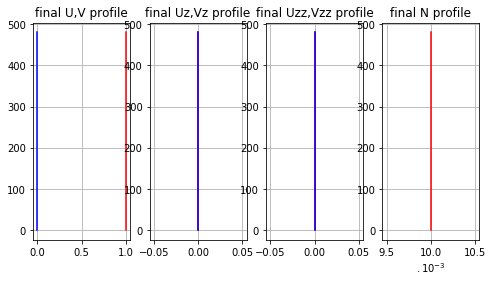

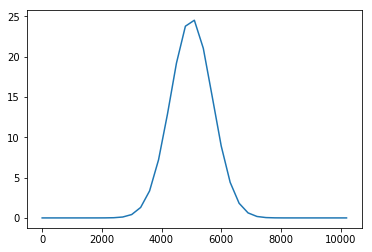

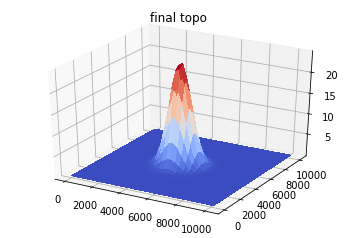

In [62]:
#creating the grid in (x,y,z) space
dx=0.3*1000
dy=0.3*1000
dz=20
Lx=5*1000
Ly=5*1000
Lz=500
'''
#to compare with cusack
dx=0.5*1000
dy=0.5*1000
dz=100
Lx=20*1000
Ly=1*1000
Lz=4000
'''

#x=np.arange(-Lx,Lx+dx,dx) #m
#y=np.arange(-Ly,Ly+dy,dy) #m
x=np.arange(0,2*Lx+dx,dx) #m
y=np.arange(0,2*Ly+dy,dy) #m
z=np.arange(0,Lz,dz)

#for sections
xx_v,zz_v=np.meshgrid(x,z) 
xx_h,yy_h=np.meshgrid(x,y)

idx_center=int(len(y)/2)

#######
#define the profiles
#######
'''
delt=100
zt=800
U1=0.8
U0=0.4
U_prof=U1*np.exp((z-zt)/delt)+U0
N=1.e-2
bvf_prof=np.ones(z.shape)*N    
'''

V0=0.0
V_prof=np.ones(z.shape)*V0   
#### attention ici c'est juste pour preparer le calcul mais par contre ça resoud pas fraiment pour un V
#### il faut que la vitesse soit uniquement le long de l'axe x


#U1=0.8
#U0=0.4
#U_prof=U1*np.exp((z-zt)/delt)+U0
U0=1.0
N=1.e-2
U_prof=np.ones(z.shape)*U0

bvf_prof=np.ones(z.shape)*N  




#define the topo

h0=25
r=700
r2=700
mu=5000




h=h0*np.exp( -0.5*((xx_h-mu)/r)**2 -0.5*((yy_h-mu)/r2)**2)

#kt=2*np.pi/5000
#h=h+h0*np.sin(kt*xx_h)*np.sin(2*kt*yy_h)

#kt=2*2*np.pi/Lx
#h=h0*np.sin(kt*xx_h)

h_new=h

#han window
tmphan1=(np.hanning(len(x)))
tmphan2=(np.hanning(len(y)))
han2d1,han2d2=np.meshgrid(tmphan1,tmphan2)
han=np.sqrt(han2d1*han2d2)
#h_new=h_new*han
    
    
#compute Uz and Vz
Uz_prof=np.zeros(U_prof.shape)
Vz_prof=np.zeros(V_prof.shape)
for i in range(0,len(Uz_prof)-1,1):
    Uz_prof[i]=(U_prof[i+1]-U_prof[i])/dz
    Vz_prof[i]=(V_prof[i+1]-V_prof[i])/dz
Uz_prof[-1]=Uz_prof[-2]
Vz_prof[-1]=Vz_prof[-2]
    

#Compute Uzz
#compute Vzz
Uzz_prof=np.zeros(U_prof.shape)
Vzz_prof=np.zeros(V_prof.shape)
for i in range(1,len(Uzz_prof)-1,1):
    Uzz_prof[i]=(U_prof[i+1]+U_prof[i-1]-2*U_prof[i])/dz**2
    Vzz_prof[i]=(V_prof[i+1]+V_prof[i-1]-2*V_prof[i])/dz**2
Uzz_prof[0]=Uzz_prof[1]
Uzz_prof[-1]=Uzz_prof[-2]         
Vzz_prof[0]=Vzz_prof[1]
Vzz_prof[-1]=Vzz_prof[-2]   
   

    
    
    
plt.figure(figsize=(8,4))
ax=plt.subplot(141)
plt.title('final U,V profile')
plt.plot(U_prof,z,'-r')
plt.plot(V_prof,z,'-b')
plt.grid()
ax=plt.subplot(142)
plt.title('final Uz,Vz profile')
plt.plot(Uz_prof,z,'-r')
plt.plot(Vz_prof,z,'-b')
plt.grid()
ax=plt.subplot(143)
plt.title('final Uzz,Vzz profile')
plt.plot(Uzz_prof,z,'-r')
plt.plot(Vzz_prof,z,'-b')
plt.grid()
ax=plt.subplot(144)
plt.title('final N profile')
#plt.plot(bvf_prof_new*1000,z)
plt.plot(bvf_prof*1000,z,'-r')
plt.xlabel(r'${\rm .10^{-3}}$')
plt.grid()
plt.show()

plt.plot(x,h_new[idx_center,:])

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
    
ax = fig.gca(projection='3d')
ax.set_title('final topo')
surf = ax.plot_surface(xx_h[:,:], yy_h[:,:], h_new[:,:], cmap='coolwarm',
                           linewidth=0, antialiased=False)
plt.show()


# Start computation of theory

In [63]:
def make_FFT2D(field,x,y,dx,dy,choix_cut):
    signal=field
    FFT=np.fft.fft2(signal,signal.shape)
    FFT=np.fft.fftshift(FFT)

    freq1=np.fft.fftfreq(len(x),dx)
    freq1=np.fft.fftshift(freq1)
    freq2=np.fft.fftfreq(len(y),dy)
    freq2=np.fft.fftshift(freq2)

    kx,ky=np.meshgrid(freq1,freq2)
    ###ATTENTION, FFTFREQ RETOURNE UNE FREQUENCE DONC 1/DX
    kx=2*np.pi*kx
    ky=2*np.pi*ky
    
    if choix_cut=='cut_bad':
        print('original shape = ',kx.shape)
        kx_cut=np.where(kx<0,np.nan,kx) #just isole the zone where kx and ky are superior to zero
        kx_cut=np.where(ky<0,np.nan,kx_cut)
        tmpcut=np.array(np.where(kx_cut>0)) #then find indices where kx and ky are superior to zero
        cut_x=tmpcut[1,0]
        cut_y=tmpcut[0,0]
        kx_cut=kx[cut_y:,cut_x:] #take only the kx ky >0 part
        ky_cut=ky[cut_y:,cut_x:]
        FFT_cut=FFT[cut_y:,cut_x:]

        #normalize with the integral
        coef=np.sum(np.abs(FFT))/np.sum(np.abs(FFT_cut))
        FFT_cut=FFT_cut*coef
        
        return FFT_cut,kx_cut,ky_cut
    
    if choix_cut=='cut':

        kx_cut=np.where(kx<0,np.nan,kx)
        kx_cut=np.where(ky<0,np.nan,kx_cut)
        FFT[np.isnan(kx_cut)==True]=np.nan


        return FFT,kx,ky
    
    if choix_cut=='diy':

        #FFT_diy
        freq1=np.fft.rfftfreq(len(x),dx)*2*np.pi
        #freq1=np.fft.fftshift(freq1)
        freq2=np.fft.rfftfreq(len(y),dy)*2*np.pi
        #freq2=np.fft.fftshift(freq2)

        kx,ky=np.meshgrid(freq1,freq2)

        exp_c=np.exp(-1j*kx[:,:,None,None]*xx_h[None,None,:,:])
        exp_c=exp_c*np.exp(-1j*ky[:,:,None,None]*yy_h[None,None,:,:])

        integrand_tf=signal[None,None,:,:]*exp_c*dx*dy
        FFT_topo=np.nansum(integrand_tf,axis=(2,3))


        return FFT,kx,ky
    
    else : return FFT,kx,ky

In [64]:
FFT_topo,kx,ky=make_FFT2D(h_new,x,y,dx,dy,0)#'cut')
FFT_topo=FFT_topo*dx*dy

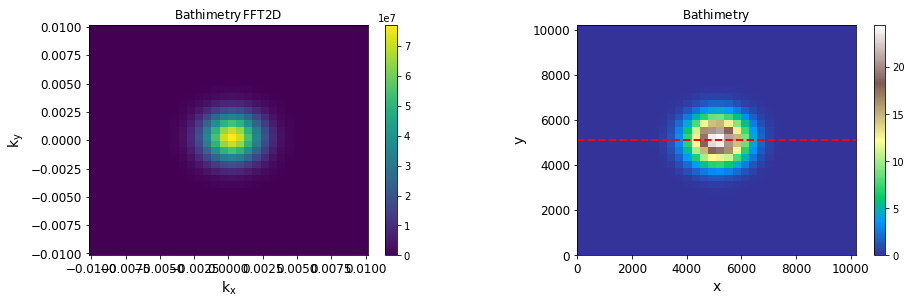

In [65]:
plt.figure(figsize=(15,4))

ax=plt.subplot(121)
plt.title(r'${\rm Bathimetry \, FFT 2D }$')
plt.pcolormesh(kx,ky,np.abs(FFT_topo))#np.log10(np.abs(FFT_topo)))
plt.colorbar()
#ax.set_xlim(0,10/1000)
plt.yticks(fontsize=12)
plt.ylabel(r'${\rm k_y}$',fontsize=14)
plt.xticks(fontsize=12)
plt.xlabel(r'${\rm k_x}$',fontsize=14)

plt.subplot(122)
plt.title(r'${\rm Bathimetry}$')
plt.pcolormesh(x,y,h_new,cmap='terrain')
plt.plot([x[0],x[-1]],[y[idx_center],y[idx_center]],'--r',linewidth=2)
plt.colorbar()
plt.yticks(fontsize=12)
plt.ylabel(r'${\rm y}$',fontsize=14)
plt.xticks(fontsize=12)
plt.xlabel(r'${\rm x}$',fontsize=14)

plt.subplots_adjust(bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.1)

#plt.savefig(pathsave_spectr+'h_w_fft_2D.png',dpi=300)

plt.show()

In [66]:
#compute profile of n

N_U2=(bvf_prof/U_prof)**2 
Uzz_U=Uzz_prof/U_prof
k2_term=(kx**2 + ky**2)/kx**2
k_term=np.sqrt(kx**2 + ky**2)/(kx)

#on factorise par le terme en k pour conserver l'orientation negative de k
kz=k_term[:,:,None]*np.sqrt(N_U2[None,None,:]  -Uzz_U[None,None,:]/k2_term[:,:,None]  )

int_kz=np.cumsum(kz*dz,axis=2)  #to make wkb approx

int_kz=int_kz-int_kz[:,:,0][:,:,None] #because integrale between 0 and 0 = 0 so remove the first step
#int_kz[:,:,0]=np.zeros(int_kz[:,:,0].shape) 

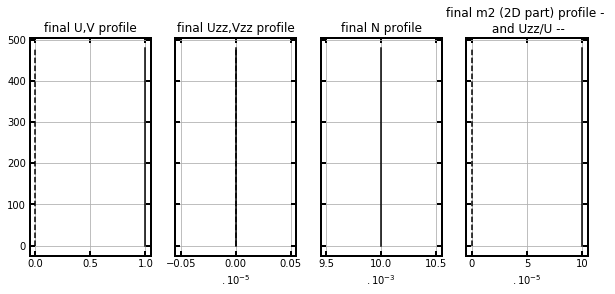

In [67]:
plt.figure(figsize=(10,4))
ax=plt.subplot(141)
plt.title('final U,V profile')
plt.plot(U_prof,z,'-k')
plt.plot(V_prof,z,'--k')
plt.grid()
ax.spines['top'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.tick_params(direction='in',width=2,length=5,bottom=1,top=1,left=1,right=1)
ax=plt.subplot(142)
plt.title('final Uzz,Vzz profile')
plt.plot(Uzz_prof*1.e5,z,'-k')
plt.plot(Vzz_prof*1.e5,z,'--k')
plt.xlabel(r'${\rm .10^{-5}}$')
ax.tick_params(labelleft='off')
plt.grid()
ax.spines['top'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.tick_params(direction='in',width=2,length=5,bottom=1,top=1,left=1,right=1)
ax=plt.subplot(143)
plt.title('final N profile')
plt.plot(bvf_prof*1000,z,'k')
plt.xlabel(r'${\rm .10^{-3}}$')
ax.tick_params(labelleft='off')
plt.grid()
ax.spines['top'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.tick_params(direction='in',width=2,length=5,bottom=1,top=1,left=1,right=1)
ax=plt.subplot(144)
plt.title('final m2 (2D part) profile - \n and Uzz/U --')
plt.plot(N_U2*1.e5,z,'k')
plt.plot(-Uzz_U*1.e5,z,'--k')
plt.xlabel(r'${\rm .10^{-5}}$')
ax.tick_params(labelleft='off')
plt.grid()
ax.spines['top'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.tick_params(direction='in',width=2,length=5,bottom=1,top=1,left=1,right=1)
#plt.savefig(pathsave+'/all_profiles_3D_WKB.png',dpi=100)
plt.show()

In [68]:
#dk for integral
dkx=np.zeros(kx.shape)
dkx[:,1:]=np.diff(kx,axis=1)
dkx[:,0]=dkx[:,1]
dky=np.zeros(ky.shape)
dky[1:,:]=np.diff(ky,axis=0)
dky[0,:]=dky[1,:]

### Compute the solution : radiation condition at the top and WKB

In [69]:
#compute eta !

BIG_one=False
### si on fait tourner à haute résolution il faut mettre BIG_one à True, pour faire une boucle sinon ca crash

if BIG_one==True :
    SUM_eta=np.zeros((len(z),len(y),len(x)))

    for iz in range (len(z)) :
        print(int(100*iz/len(z)),"%")
        print('compute integrand ')
        expon_c=np.exp(1j*kx[:,:,None,None]*xx_h[None,None,:,:])
        expon_c=expon_c*np.exp(1j*ky[:,:,None,None]*yy_h[None,None,:,:])
        WKB_term=np.exp(1j*(int_kz[:,:,iz]))*np.sqrt(kz[:,:,0]/kz[:,:,iz])
        if iz==0 : WKB_term[:,:]=np.ones(WKB_term[:,:].shape)
        integrand=FFT_topo[:,:,None,None]*WKB_term[:,:,None,None]*expon_c[:,:,:,:]
        integrand=integrand*(dkx*dky)[:,:,None,None]
        print('compute sum ')
        SUM_eta[iz,:,:]=(1/(2*np.pi)**2)*np.nansum(integrand,axis=(0,1))
else :
    

    expon_c=np.exp(1j*kx[:,:,None,None]*xx_h[None,None,:,:])
    expon_c=expon_c*np.exp(1j*ky[:,:,None,None]*yy_h[None,None,:,:])
    WKB_term=np.exp(1j*(int_kz))*np.sqrt(kz[:,:,0][:,:,None]/kz)
    WKB_term[:,:,0]=np.ones(WKB_term[:,:,0].shape)
    #WKB_term=np.where(np.isnan(WKB_term[:,:,:])==True,1,WKB_term[:,:,:]) #remove problem where kz is not defined
    integrand=FFT_topo[:,:,None,None,None]*WKB_term[:,:,:,None,None]*expon_c[:,:,None,:,:]
    integrand=integrand*(dkx*dky)[:,:,None,None,None]
    print('compute sum')
    SUM_eta=(1/(2*np.pi)**2)*np.nansum(integrand,axis=(0,1))


    
    
eta=np.real(SUM_eta)

compute sum


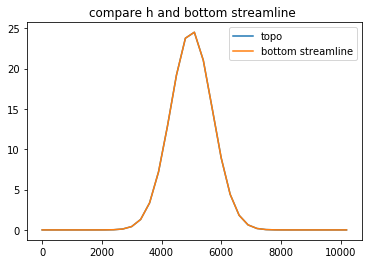

In [70]:
plt.title('compare h and bottom streamline ')
plt.plot(x,h_new[idx_center,:],label='topo')
plt.plot(x[:],eta[0,idx_center,:],label='bottom streamline')
plt.legend()
plt.show()

#d'apres la theorie, la streamline au fond == la topo, 
#on verifie juste ça pour etre sur que le calcul soit juste

In [71]:
#compute pressure with WKB profiles


#compute pressure at the bottom
rho0=1027.4
g=9.81
integrand_P0=1j*FFT_topo[:,:,None,None]*expon_c[:,:,:,:]
integrand_P0=integrand_P0/kz[:,:,0,None,None]*(dkx*dky)[:,:,None,None]
print('compute sum')
P0=(rho0*bvf_prof[0]**2/(2*np.pi)**2)*np.nansum(integrand_P0,axis=(0,1)) 
P0=np.real(P0)



#compute the pressure from eta : beware the P0 !!
integrand_P=-rho0*eta*(bvf_prof[:,None,None])**2
SUM_z_P=np.cumsum(integrand_P,axis=0)*dz
SUM_z_P=SUM_z_P-SUM_z_P[0]
P=np.real(SUM_z_P)+P0

compute sum


In [72]:
#compute anomaly of density and buoyancy
buoy=-bvf_prof[:,None,None]**2 * eta
rho=-buoy*rho0/g

In [73]:
#compute vertical velocity anomaly
#w=U_prof[:,None,None]*(eta[:,:,1:]-eta[:,:,:-1])/(dx) 
w=U_prof[:,None,None]*np.gradient(eta,dx,axis=2)

In [74]:
##compute horizontal velocity anomalies
#true just for V==0 !!!

#first compute pressure gradient
dx_P=np.gradient(P,dx,axis=2)  ### maybe change that if it goes wild
dy_P=np.gradient(P,dy,axis=1)
#compute velocity gradients from pressure
dx_u=-((1/rho0)*dx_P[:,:,:] + Uz_prof[:,None,None]*w)/U_prof[:,None,None]
dx_v=-((1/rho0)*dy_P[:,:,:] )/U_prof[:,None,None]
#integrate along x axis
u=np.cumsum(dx_u,axis=2)*dx
v=np.cumsum(dx_v,axis=2)*dx

In [75]:
#compute gradients of velocities :
dx_u=np.gradient(u,dx,axis=2)
dy_u=np.gradient(u,dy,axis=1)
dx_v=np.gradient(v,dx,axis=2)
dy_v=np.gradient(v,dy,axis=1)


#compute divergence
D=dx_u+dy_v

#compute strain
S1=dx_u-dy_v #Stretching
S2=dx_v+dy_u #Shear
S=np.sqrt(S1**2+S2**2) #Strain 

In [76]:
#compute energy densities
Ec=0.5*rho0*(u**2+v**2+w**2)
Ep=0.5*g**2 * rho**2/(rho0*bvf_prof[:,None,None]**2)

In [77]:
#compute energy flux
#P_dx=0.5*(P[:,:,1:]+P[:,:,:-1])
FeX=P*u
FeY=P*v
FeZ=P*w
#the 3 components allow to find direction of the group velocity
#compute vetical QdM flux
FmZ=rho0*np.sqrt((u*w)**2+(v*w)**2)

#FeZ in W/m2
#to compute energy transfered into lee waves over all the domain : int int dx dy Fez
Ener_bot=np.nansum(FeZ[0]*dx*dy,axis=(0,1))

In [78]:
dxFeX=np.gradient(FeX,dz,axis=2)
dyFeY=np.gradient(FeY,dz,axis=1)
dzFeZ=np.gradient(FeZ,dz,axis=0)
sumFlux=dxFeX+dyFeY+dzFeZ

In [79]:
#compute angle of rays in the x z plane 
#(angle with respect to horizontal)
angle_xz_cg_rad=np.arctan2(FeZ[:,idx_center,:],FeX[:,idx_center,:])
angle_xz_cg=(np.rad2deg(angle_xz_cg_rad))
#if we want to compare with analytical value of the angle for a sinusoidal topo
#no rotation
#kt=cste
#arg=np.sqrt(kt**2 *U_prof**2/(bvf_prof**2-kt**2 *U_prof**2))
#theta=180-np.rad2deg(np.arctan(arg)) #angle with horizontal 
#plt.plot(theta,z)
#plt.show()

In [80]:
#compute aspect ratio
alpha=w**2/(u**2+v**2) #not very useful because it diverges

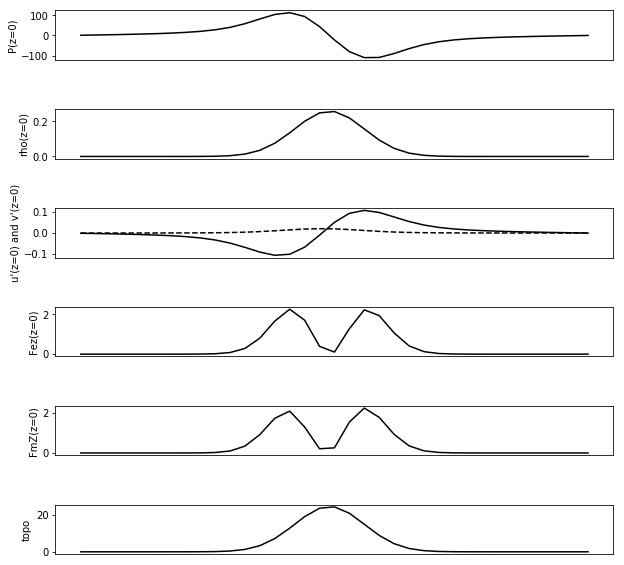

In [81]:
fig=plt.figure(figsize=(10,10))
ax=plt.subplot(611)
plt.ylabel('P(z=0)')
plt.plot(x,P[0,idx_center,:],'-k')
plt.xticks([])
ax=plt.subplot(612)
plt.ylabel('rho(z=0)')
plt.plot(x,rho[0,idx_center,:],'-k')
plt.xticks([])
ax=plt.subplot(613)
plt.ylabel("u'(z=0) and v'(z=0)")
plt.plot(x[:],u[0,idx_center,:],'-k')
plt.plot(x[:],v[0,idx_center,:],'--k')
plt.xticks([])
ax=plt.subplot(614)
plt.ylabel('Fez(z=0)')
plt.plot(x[:],FeZ[0,idx_center,:],'-k')
#plt.plot(x[:],FeX[0,idx_center,:],'-k')
#plt.plot(x[:],FeY[0,idx_center,:],'-k')
plt.xticks([])
ax=plt.subplot(615)
plt.ylabel('FmZ(z=0)')
plt.plot(x[:],FmZ[0,idx_center,:],'-k')
plt.xticks([])
ax=plt.subplot(616)
plt.ylabel('topo')
plt.plot(x[:],h_new[idx_center,:],'-k')
plt.xticks([])
plt.subplots_adjust(hspace=1)
plt.savefig('recap_bottom.png',dpi=200)
plt.show()

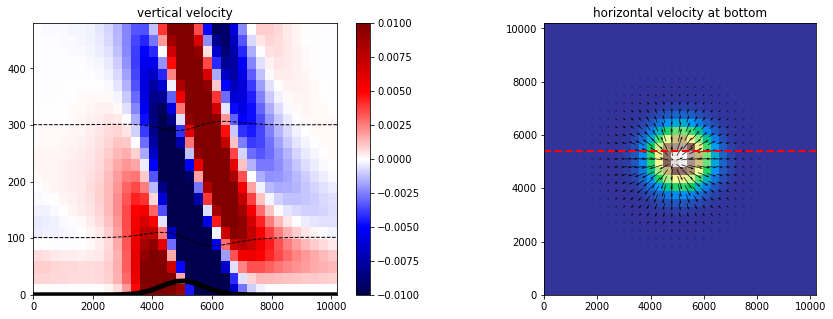

In [82]:
plt.figure(figsize=(15,5))
ax=plt.subplot(121)
plt.title('vertical velocity')
plt.pcolormesh(x,z,w[:,idx_center,:],vmin=-0.01,vmax=0.01,cmap='seismic')
#plt.pcolormesh(x,z,angle_xz_cg[:,:])
plt.plot(x,h_new[idx_center,:],'-k',linewidth=5)

plt.colorbar()
ax.set_ylim(np.min(h_new[idx_center,:]),z[-1])


for i in range(5,len(zz_v[:,0]),10):
    eta_tmp=eta[i,idx_center,:]+zz_v[i,0]
    plt.plot(x[:],eta_tmp,'--',color='k',linewidth=1,zorder=12)
    
    
#plot a ray
ray=0
if ray==1:
    X0=[6000]
    Y0=[0]
    for i in range(len(X0)):
        deltaY=100
        x0=X0[i]
        y0=Y0[i]
        tmp1=xx_v<x0+dx/2
        tmp2=xx_v>x0-dx/2
        tmp3=zz_v<y0+dz/2
        tmp4=zz_v>y0-dz/2
        zone=tmp1&tmp2&tmp3&tmp4

        theta_tmp=np.abs(angle_xz_cg_rad[zone])
        y1=deltaY
        x1=y1/np.tan(theta_tmp)
        y1=y1+y0
        x1=x1+x0
        plt.annotate("", xy=(x1,y1), xytext=(x0, y0),
                    arrowprops=dict(width=2,headwidth=10,color='w'))  #arrowstyle="-["
        #plt.plot([x0,x1],[y0,y1],'--k',linewidth=5,alpha=0.8)


ax=plt.subplot(122,aspect='equal')
plt.title('horizontal velocity at bottom')
plt.pcolormesh(xx_h,yy_h,h_new,cmap='terrain')#,vmin=-0.05,vmax=0.05)   
plt.plot([x[0],x[-1]],[y[idx_center+1],y[idx_center+1]],'--r',linewidth=2)
plt.quiver(xx_h,yy_h,u[0,:,:],v[0,:,:],pivot='mid',scale=2)    
        
plt.savefig('recap_uvw')
plt.show()

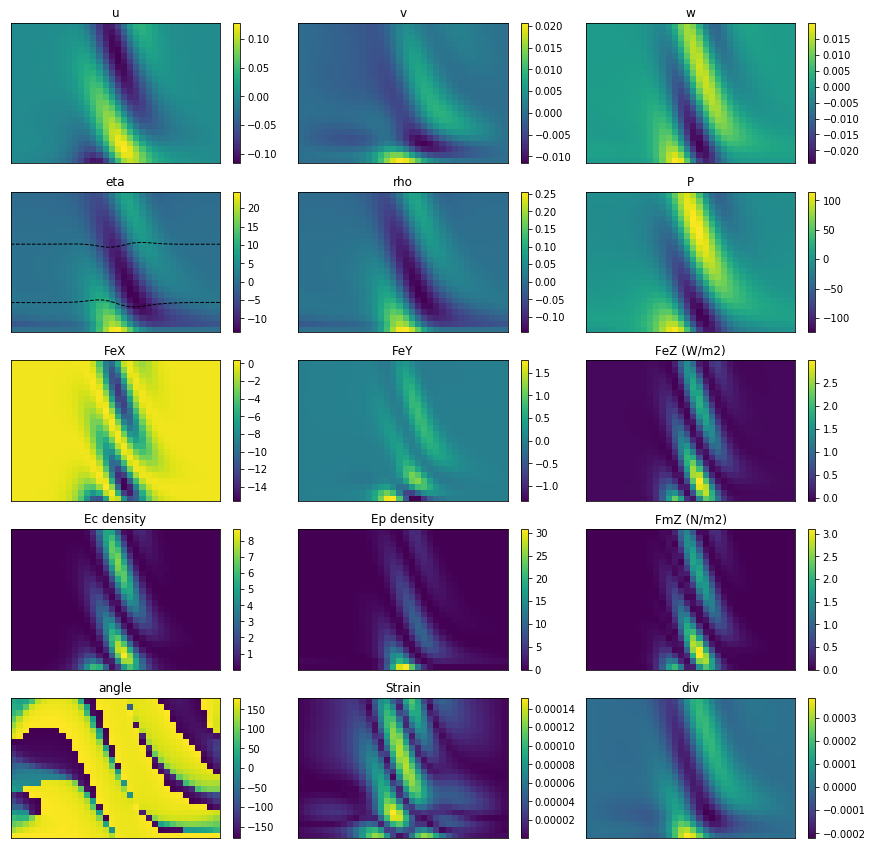

In [83]:
plt.figure(figsize=(15,15))
plt.subplot(531)
plt.title('u')
plt.xticks([])
plt.yticks([])
plt.pcolormesh(x,z,u[:,idx_center,:])
plt.colorbar()
plt.subplot(532)
plt.title('v')
plt.xticks([])
plt.yticks([])
plt.pcolormesh(x,z,v[:,idx_center,:])
plt.colorbar()
plt.subplot(533)
plt.title('w')
plt.xticks([])
plt.yticks([])
plt.pcolormesh(x,z,w[:,idx_center,:])
plt.colorbar()
plt.subplot(534)
plt.title('eta')
plt.xticks([])
plt.yticks([])
plt.pcolormesh(x,z,eta[:,idx_center,:])
plt.colorbar()
for i in range(5,len(zz_v[:,0]),10):
    eta_tmp=eta[i,idx_center,:]+zz_v[i,0]
    plt.plot(x[:],eta_tmp,'--',color='k',linewidth=1,zorder=12)
plt.subplot(535)
plt.title('rho')
plt.xticks([])
plt.yticks([])
plt.pcolormesh(x,z,rho[:,idx_center,:])
plt.colorbar()    
plt.subplot(536)
plt.title('P')
plt.xticks([])
plt.yticks([])
plt.pcolormesh(x,z,P[:,idx_center,:])
plt.colorbar()
plt.subplot(537)
plt.title('FeX')
plt.xticks([])
plt.yticks([])
plt.pcolormesh(x,z,FeX[:,idx_center,:])
plt.colorbar()
plt.subplot(538)
plt.title('FeY')
plt.xticks([])
plt.yticks([])
plt.pcolormesh(x,z,FeY[:,idx_center,:])
plt.colorbar()
plt.subplot(539)
plt.title('FeZ (W/m2)')
plt.xticks([])
plt.yticks([])
plt.pcolormesh(x,z,FeZ[:,idx_center,:])
plt.colorbar()
plt.subplot(5,3,10)
plt.title('Ec density')
plt.xticks([])
plt.yticks([])
plt.pcolormesh(x,z,Ec[:,idx_center,:])
plt.colorbar()
plt.subplot(5,3,11)
plt.title('Ep density')
plt.xticks([])
plt.yticks([])
plt.pcolormesh(x,z,Ep[:,idx_center,:])
plt.colorbar()
plt.subplot(5,3,12)
plt.title('FmZ (N/m2)')
plt.xticks([])
plt.yticks([])
plt.pcolormesh(x,z,FmZ[:,idx_center,:])
plt.colorbar()
plt.subplot(5,3,13)
plt.title('angle')
plt.xticks([])
plt.yticks([])
plt.pcolormesh(x,z,angle_xz_cg[:,:])
plt.colorbar()
plt.subplot(5,3,14)
plt.title('Strain')
plt.xticks([])
plt.yticks([])
plt.pcolormesh(x,z,S[:,idx_center,:])
plt.colorbar()
plt.subplot(5,3,15)
plt.title('div')
plt.xticks([])
plt.yticks([])
plt.pcolormesh(x,z,D[:,idx_center,:])
plt.colorbar()




plt.subplots_adjust(wspace=0.1,hspace=0.2)

plt.savefig('recap_all_sect.png')

plt.show()
